<a href="https://colab.research.google.com/github/HRashidLiaquat/lessons-learned/blob/Transformer-based-crop-disease-detection-system/Agri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Workflow**


1.   Import Important Libraries
2.   Get Data Ready in Kaggle
3.   Preparing data
4.   Loading Training Images
5.   Data Loaders
6.   Build a Traning Model (Transfer Learning)
7.   Model Training
8.   Model Testing (Training Loop)
9.   Model Evaluation
10.  Testing with New Data Point
11.  Save Model








**Import Important libraries**

In [1]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
import zipfile
import random
import matplotlib.pyplot as plt



**Mount GDrive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Zip to unZip data**

In [3]:
zip_path = Path("/content/drive/MyDrive/Colab Notebooks/agriarchive.zip")
extract_path = Path("/content/data")

print("ZIP exists:", zip_path.exists())

extract_path.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

ZIP exists: True


**Get Ready dataset**

In [4]:
datset_path = Path('/content/data/PlantVillage')

if datset_path.exists():
  print("Dataset found!")
else:
  print("Dataset not found!")

Dataset found!


In [5]:
if datset_path.exists():
  datsetfolderlist = list(datset_path.iterdir())
  print("See all folder in my dataset main folder")
  for allfolder in datsetfolderlist:
      print(allfolder)

See all folder in my dataset main folder
/content/data/PlantVillage/val
/content/data/PlantVillage/train


**Check Total plant classes data**

In [6]:

traning_path = datset_path / '/content/data/PlantVillage/train'
print(traning_path)
test_path = datset_path / '/content/data/PlantVillage/train/val'
train_classes = [item.name for item in traning_path.iterdir() if item.is_dir()]
train_classes.sort()
num_classes = len(train_classes)
print(f"Total plant classes: {num_classes}")

/content/data/PlantVillage/train
Total plant classes: 38


**Display Raw data**

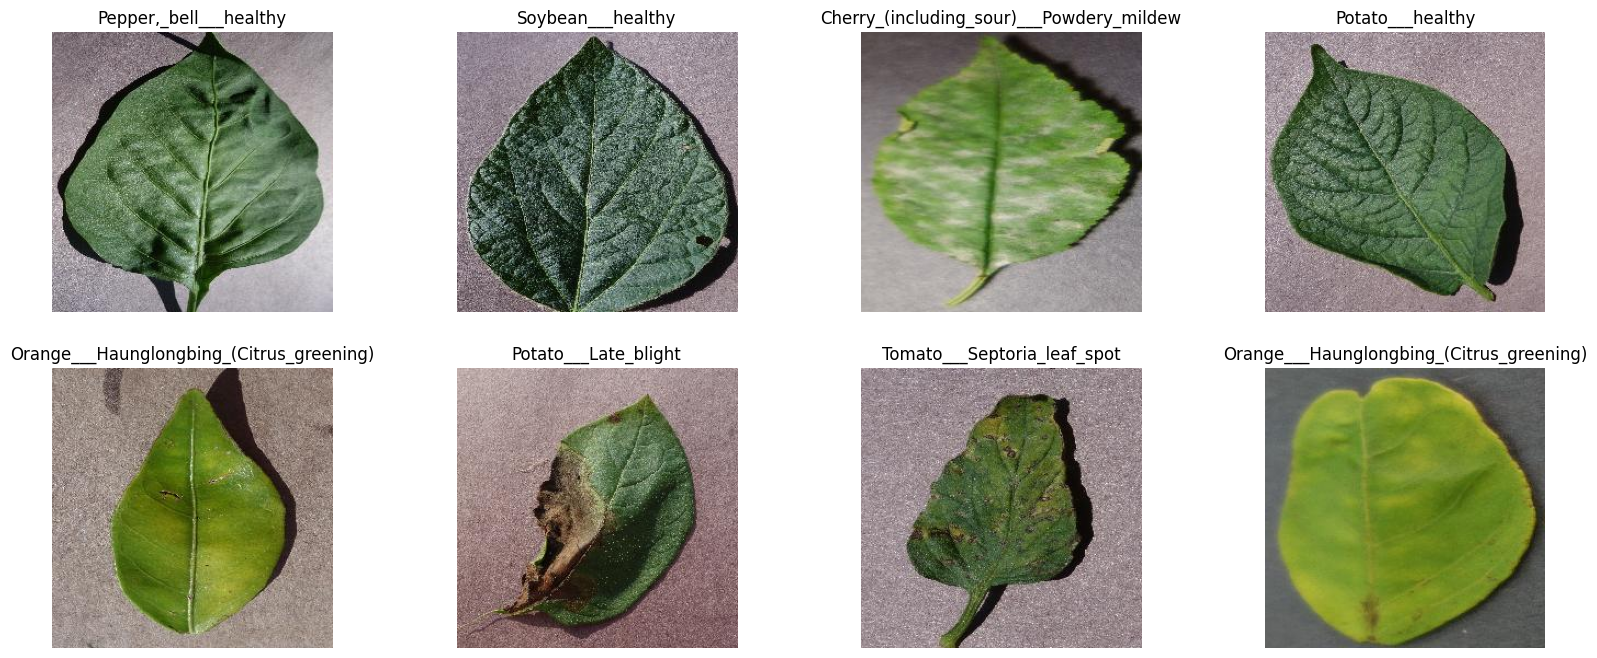

In [7]:
rawdataset = datasets.ImageFolder(traning_path, transform=transforms.ToTensor())

plt.figure(figsize=(20, 8))
for i in range(8):
    idx = random.randint(0, len(rawdataset)-1)
    img, label = rawdataset[idx]
    plt.subplot(2, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(rawdataset.classes[label])
    plt.axis('off')

**Data Preprocessing (Normalization and augmentation)**

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 16

**Data Augmentattion**

In [9]:
aug_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2,0.2,0.2)

])

In [10]:
aug_transforms

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
)

**Data Preprocessing**



In [11]:
prepro_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [12]:
prepro_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

**Data Normaliztion**

In [13]:
normalization_transform = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

In [14]:
normalization_transform

Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [15]:
train_trasform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Show Data after Preprocessing**

In [16]:
processed_datase = datasets.ImageFolder(traning_path, transform=transforms.ToTensor())
def denorm(x):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return torch.clamp(x * std + mean, 0, 1)


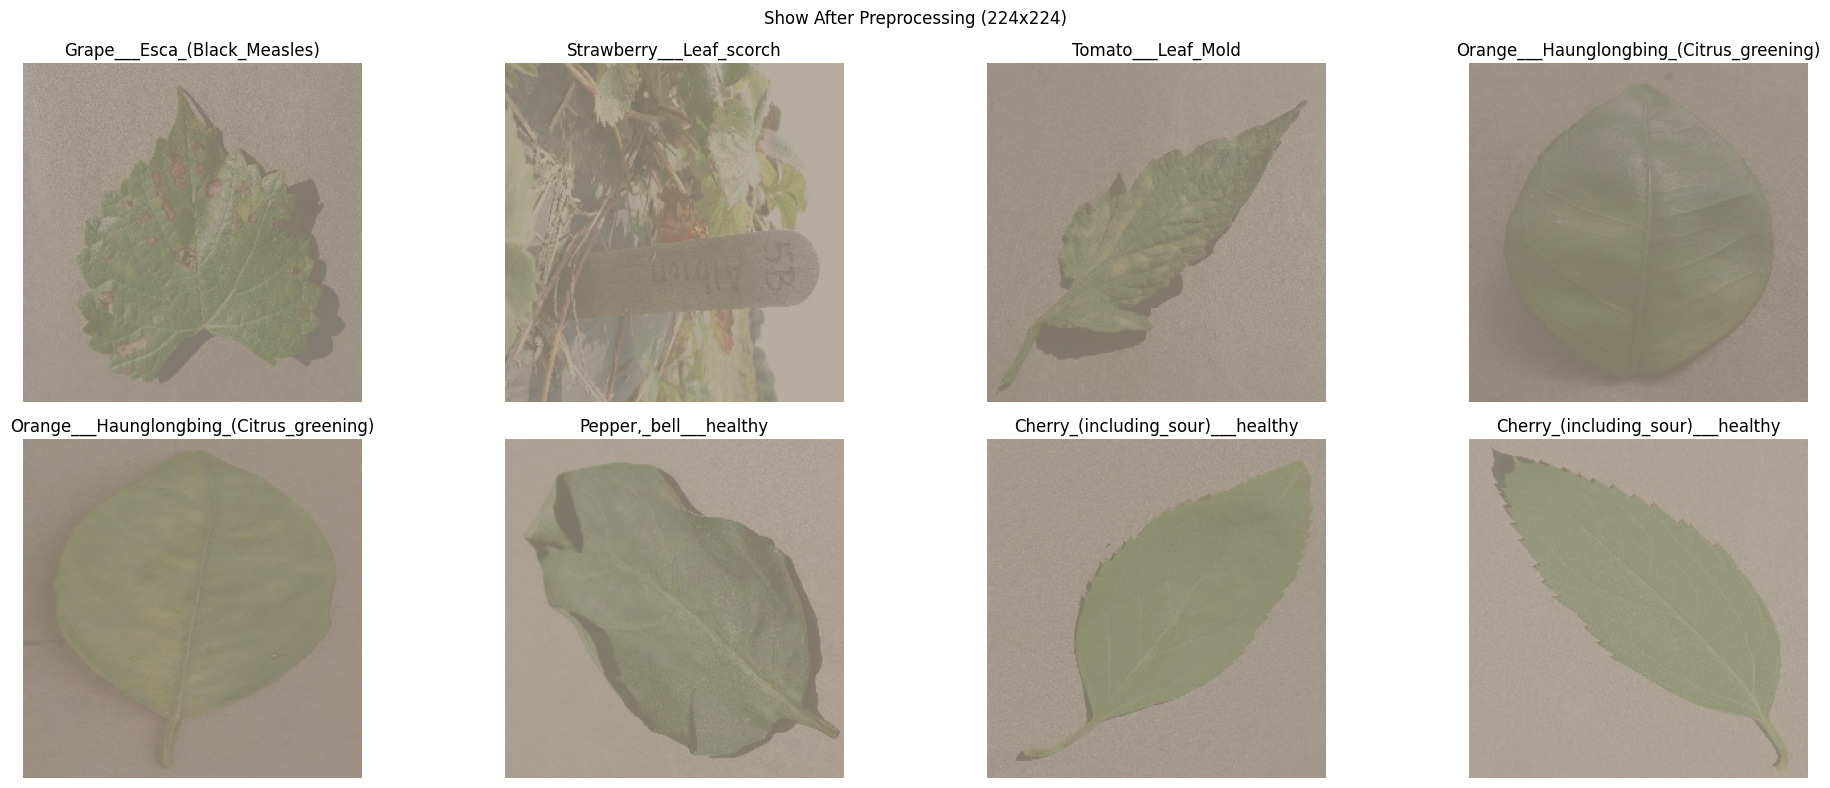

In [17]:
plt.figure(figsize=(20, 8))
for i in range(8):
    idx = random.randint(0, len(processed_datase)-1)
    img, label = processed_datase[idx]

    img = denorm(img)

    plt.subplot(2, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(processed_datase.classes[label])
    plt.axis('off')

plt.suptitle('Show After Preprocessing (224x224)')
plt.tight_layout()
plt.show()

**Load Dataset**

In [18]:
dataset = datasets.ImageFolder(datset_path, transform=train_trasform)
print("Total images:", len(dataset))
print("Classes:", dataset.classes)

Total images: 54305
Classes: ['train', 'val']
